# Bayesian Inference with NumPyro & jax-cosmo

<a href="https://colab.research.google.com/github/ASKabalan/Tutorials/blob/main/BDL2025/Exercises/01_Beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome! In this notebook, we'll walk through the basics of Bayesian inference in a cosmological context using **NumPyro**, **BlackJAX**, and **jax-cosmo**.

We'll begin with a simple **linear regression** example to introduce the syntax and mechanics of probabilistic modeling with NumPyro.

Along the way, we'll explore:
- 🔁 **Reproducibility** using `numpyro.handlers.seed`
- 🕵️ **Model inspection** with `trace`
- 📎 **Conditioning** models with observed values (`condition`)
- 📈 **Posterior visualization** using `ArviZ` and `corner`

---

### 📦 Part II: Cosmological Inference

You will then move on to a more realistic cosmology task:
> Perform Bayesian inference on cosmological parameters  
> using simulated data and **angular power spectra** from `jax-cosmo`.




## Part I: Simple Linear Regression with NumPyro

Let's begin with a simple example to get familiar with **Bayesian modeling** using `NumPyro`.

We'll model a set of synthetic data drawn from a linear function with noise:

$$
y = w \cdot x + b + \epsilon
$$

Our goal is to **infer the slope `w`, intercept `b`, and noise level `σ`** from the data using Bayesian inference.


In [1]:
!pip install -q numpyro arviz matplotlib corner blackjax chainconsumer getdist

In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az
import matplotlib.pyplot as plt
import corner

### Step 1 — Generate synthetic data for linear regression


In [2]:
true_w = 2.0
true_b = -1.0
num_points = 100

rng_key = jax.random.PRNGKey(0)
x_data = jnp.linspace(-3, 3, num_points)
noise = jax.random.normal(rng_key, shape=(num_points,)) * 0.3
y_data = true_w * x_data + true_b + noise


### Step 2 — Define the NumPyro probabilistic model


In [3]:
def linear_regression(x, y=None):
    w = numpyro.sample("w", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mean = w * x + b
    numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)


### Step 3 — Run inference with the NUTS sampler


In [4]:
kernel = numpyro.infer.NUTS(linear_regression)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, x=x_data, y=y_data)


sample: 100%|██████████| 1500/1500 [00:08<00:00, 172.02it/s, 7 steps of size 8.59e-01. acc. prob=0.90] 


### Step 4 — Visualize the posterior distribution


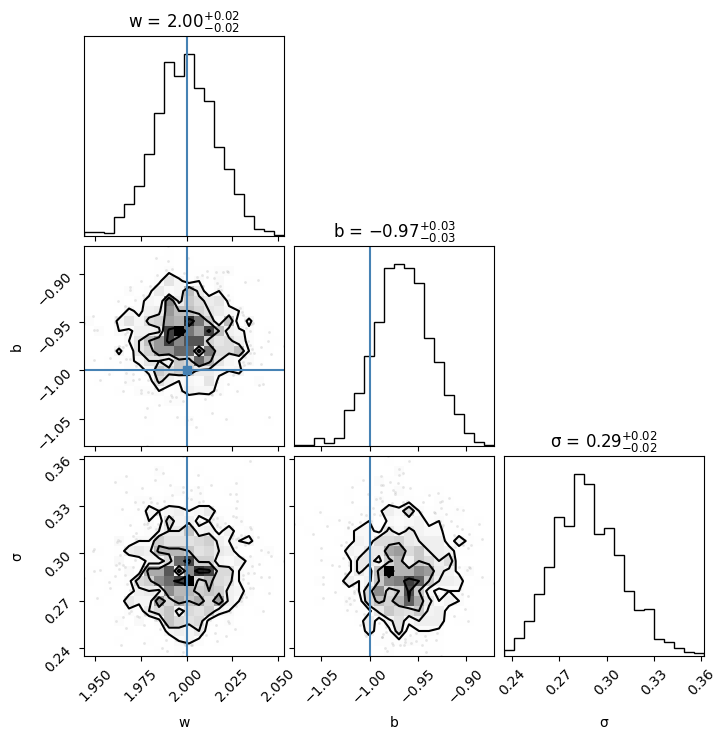

In [5]:
idata = az.from_numpyro(mcmc)
posterior_array = az.extract(idata, var_names=["w", "b", "sigma"]).to_array().values.T

fig = corner.corner(
    posterior_array,
    labels=["w", "b", "σ"],
    truths=[true_w, true_b, None],
    show_titles=True
)
plt.show()


#### **Posterior Diagnostics Cell**

In [6]:
az.summary(idata, var_names=["w", "b", "sigma"])


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w,1.999,0.017,1.968,2.031,0.001,0.000,1066.0,733.0,NaN
b,-0.966,0.030,-1.019,-0.910,0.001,0.001,903.0,660.0,NaN
sigma,0.288,0.021,0.250,0.329,0.001,0.001,1019.0,842.0,NaN


### Evaluating MCMC Chain Diagnostics

When you run Bayesian inference with MCMC (e.g. via NumPyro), the resulting posterior summary table includes key statistics to assess **inference quality** and **parameter uncertainty**. Here's how to interpret the columns:

| Metric        | Meaning                                                                 |
|---------------|-------------------------------------------------------------------------|
| **mean**      | The estimated posterior mean of the parameter                           |
| **sd**        | The standard deviation of the posterior — represents **uncertainty**    |
| **hdi_3% / hdi_97%** | 94% **Highest Density Interval (HDI)** — a credible interval covering the most likely values |
| **mcse_mean** | **Monte Carlo Standard Error** of the mean — how accurate the mean estimate is |
| **mcse_sd**   | MCSE of the standard deviation — accuracy of uncertainty estimation     |
| **ess_bulk**  | **Effective Sample Size** in the bulk — indicates independent information in the center of the posterior |
| **ess_tail**  | ESS in the tails — important for detecting problems with extremes or multimodal posteriors |
| **r_hat**     | **Convergence diagnostic** (should be ≈ 1.0); NaN if only one chain is used |

#### ✅ What to look for:

- **Low `mcse_mean` and `mcse_sd`** (≪ posterior `sd`) → your estimates are stable  
- **High `ess_bulk` and `ess_tail`** (ideally > 400) → good sampling efficiency  
- **`r_hat ≈ 1.0`** (or NaN if single chain) → chains have converged  
- **Symmetric `hdi`** interval around mean → roughly Gaussian posterior

If diagnostics are poor (e.g. low ESS, high MCSE, or `r_hat > 1.01`), consider:
- Increasing `num_samples` or `num_warmup`
- Reparameterizing the model
- Using more chains


### MAP Estimation from Posterior Samples

While the posterior **mean** summarizes the expected value of each parameter, the **Maximum A Posteriori (MAP)** estimate identifies the **most probable** parameter value — i.e., the **mode** of the posterior.

In this example, we estimate the MAP for each parameter individually using **Kernel Density Estimation (KDE)**:
- We fit a KDE to the 1D marginal posterior of each parameter.
- Then we find the location where the KDE reaches its maximum (i.e., the mode).

This gives us a practical way to approximate the MAP from posterior samples, especially for well-behaved unimodal distributions.

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

# Extract posterior samples from ArviZ
posterior_samples = az.extract(idata, var_names=["w", "b", "sigma"]).to_dataframe()

# Compute MAP using 1D KDE mode for each parameter
def compute_map_kde(samples_1d):
    kde = gaussian_kde(samples_1d)
    x = np.linspace(samples_1d.min(), samples_1d.max(), 1000)
    pdf = kde(x)
    return x[np.argmax(pdf)]

map_estimates = {
    param: compute_map_kde(posterior_samples[param].values)
    for param in ["w", "b", "sigma"]
}

print("MAP Estimates:")
for param, value in map_estimates.items():
    print(f"{param} ≈ {value:.4f}")

### **Compute Log Model Evidence via Posterior Log-Likelihoods**

Once you've run inference and obtained posterior samples with `NumPyro`, you can estimate the **log model evidence** using **importance sampling**. This method approximates:

$$
\log p(y) \approx \log \left( \frac{1}{N} \sum_{i=1}^N p(y \mid \theta_i) \right)
$$

Where $\theta_i$ are your posterior samples, and $p(y \mid \theta_i)$ is the likelihood evaluated at each sample.

This approach uses the **log-mean-exp** trick for numerical stability.

>Note: This is not the exact marginal likelihood. For true evidence comparison, use SVI (ELBO) or bridge sampling.

In [7]:
from numpyro.infer import log_likelihood
from jax.scipy.special import logsumexp
import jax.numpy as jnp

# Step 1: Compute log-likelihood per data point, per posterior sample
log_lik = log_likelihood(linear_regression, mcmc.get_samples(), x=x_data, y=y_data)['obs']  # shape [num_samples, num_points]

# Step 2: Sum over data points to get total log-likelihood for each sample
log_lik_sum = jnp.sum(log_lik, axis=-1)  # shape [num_samples]

# Step 3: Use log-mean-exp trick to estimate log evidence
log_evidence = logsumexp(log_lik_sum) - jnp.log(log_lik_sum.shape[0])

print("Estimated Log Model Evidence:", log_evidence)


Estimated Log Model Evidence: -16.588097


## Using different packages for visualization

### Triangle Plot with GetDist

[**GetDist**](https://getdist.readthedocs.io/) is a Python package for generating high-quality triangle plots, commonly used in cosmology. It displays marginalized 1D and 2D posterior distributions with confidence contours.

In the cell below, we convert the NumPyro posterior samples into a `GetDist`-compatible format and use it to visualize the joint distribution of `w`, `b`, and `σ`, along with the true parameter values used to generate the synthetic data.


Removed no burn in


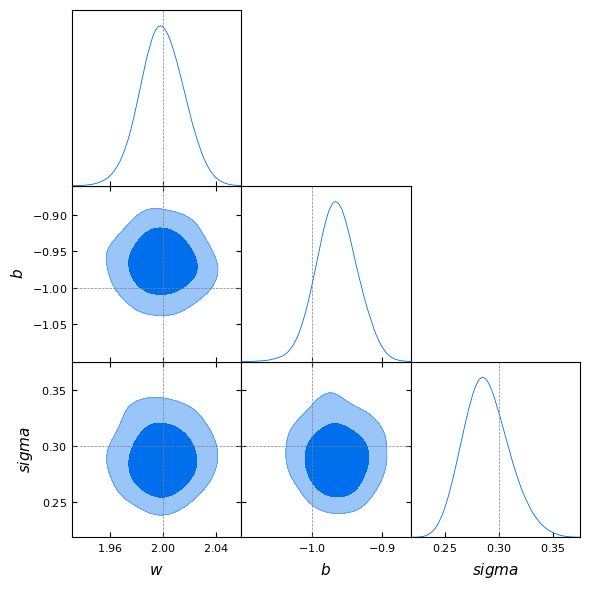

In [19]:
from getdist import MCSamples, plots
import matplotlib.pyplot as plt
import arviz as az

# Step 1: Extract and clean samples
df = az.extract(idata, var_names=["w", "b", "sigma"]).to_dataframe().drop(columns=["chain", "draw"])

# Step 2: Convert to NumPy and define names/labels
samples_array = df[["w", "b", "sigma"]].to_numpy()
param_names = ["w", "b", "sigma"]
param_labels = ["w", "b", "sigma"]

# Step 3: Create GetDist MCSamples
gd_samples = MCSamples(samples=samples_array, names=param_names, labels=param_labels)

# Step 4: Plot with truth values mapped to parameter names
g = plots.get_subplot_plotter()
g.triangle_plot(
    gd_samples,
    filled=True,
    markers={"w": true_w, "b": true_b, "sigma": 0.3}  # explicitly name truths
)


### Visualizing Posteriors with ChainConsumer

[**ChainConsumer**](https://samreay.github.io/ChainConsumer/) is a powerful and flexible Python package for visualizing MCMC chains and posterior distributions. It is particularly well-suited for generating corner plots with:
- 1D and 2D marginalized distributions
- Contour levels for multiple confidence intervals (e.g., 68%, 95%)
- Custom styling and color maps
- Truth markers and derived parameters
- Publication-ready plots

ChainConsumer supports both a simple API and a more advanced, object-oriented configuration via `Chain`, `ChainConfig`, `Truth`, and `PlotConfig` for full control over the plot appearance.

We use ChainConsumer here to explore the posterior distribution of our model parameters and optionally overlay "truth" values used to generate synthetic data.


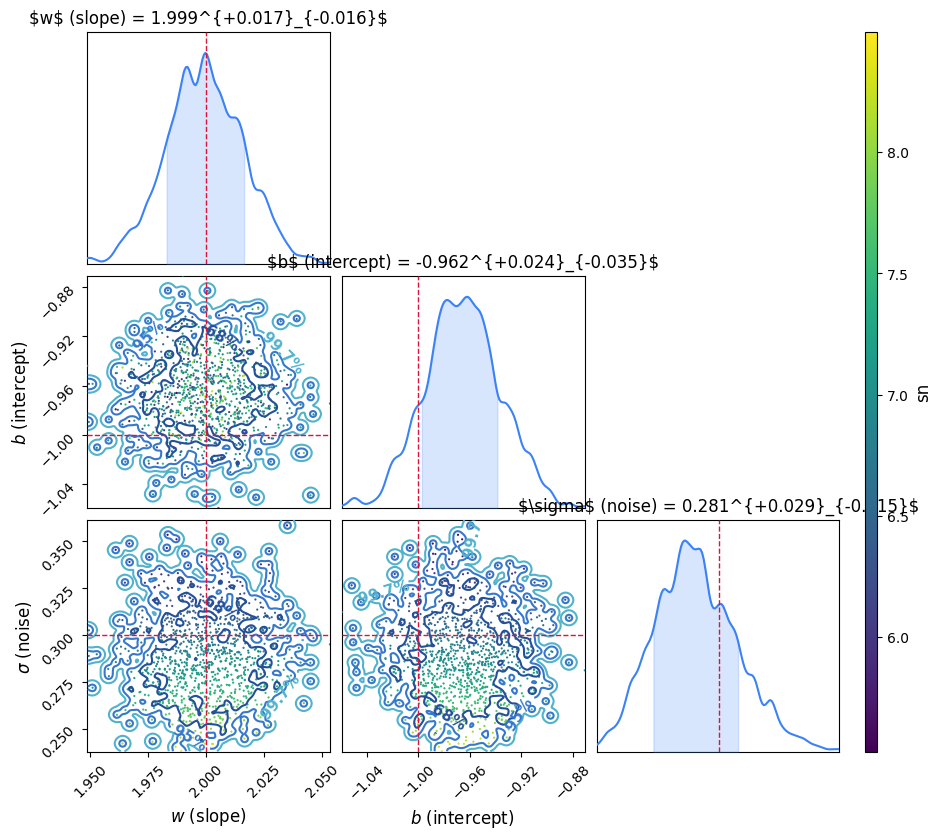

In [11]:
from chainconsumer import ChainConsumer, Chain, ChainConfig, PlotConfig, Truth

# Extract posterior samples as DataFrame
posterior_samples = az.extract(idata, var_names=["w", "b", "sigma"]).to_dataframe()

# Optional: add a derived column for demonstration (e.g., posterior signal-to-noise)
posterior_samples = posterior_samples.assign(sn=lambda df: df["w"] / df["sigma"])
posterior_samples = posterior_samples.drop(columns=["chain", "draw"])
# Create ChainConsumer and configure the chain
c = ChainConsumer()

chain = Chain(
    samples=posterior_samples,
    name="Linear Regression Posterior",
    color="blue",
    plot_point=True,
    plot_cloud=True,
    marker_style="o",
    marker_size=50,
    num_cloud=5000,
    shade=False,
    linewidth=1.5,
    cmap="viridis",
    show_contour_labels=True,
    color_param="sn",  # Use derived "sn" for coloring
)

c.add_chain(chain)

# Override contour levels globally (1σ, 2σ, 3σ)
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))

# Add truth markers for comparison
c.add_truth(Truth(location={"w": true_w, "b": true_b, "sigma": 0.3}, color="crimson"))

# Configure axis labels and plot style
c.set_plot_config(
    PlotConfig(
        flip=True,
        labels={
            "w": r"$w$ (slope)",
            "b": r"$b$ (intercept)",
            "sigma": r"$\sigma$ (noise)",
        },
        contour_label_font_size=11,
    )
)

# Generate and show the plot
fig = c.plotter.plot()


#### 📓 **Quick Cheat Sheet**


##### 🔧 Useful NumPyro & ArviZ Tools

- `numpyro.sample(...)`: Define priors and likelihoods
- `numpyro.handlers.seed(...)`: Fix randomness
- `numpyro.handlers.condition(...)`: Inject known values
- `numpyro.handlers.trace(...)`: Inspect what happens in the model
- `numpyro.infer.MCMC(...)`: Run inference
- `arviz.from_numpyro(...)`: Convert results for analysis
- `arviz.plot_pair(...)`: Visualize 2D posterior KDE
- `arviz.summary(...)`: Diagnostics (ESS, R-hat, mean/HDI)
```

### Inspecting model execution with `seed` and `trace`

We can use NumPyro's `handlers` to trace the execution of our model and see what random variables are sampled.  
This is useful for debugging and understanding the internal structure of the model.


In [7]:
from numpyro.handlers import seed, trace

# Set up a seeded trace to inspect one run of the model
rng_key = jax.random.PRNGKey(123)
traced_model = trace(seed(linear_regression, rng_key)).get_trace(x_data)

# Print sampled values
for name, site in traced_model.items():
    if site['type'] == 'sample':
        print(f"{name}: {site['value']}")


w: -0.7828053832054138
b: -1.858533501625061
sigma: 0.2632538080215454
obs: [ 0.42458665  0.20469339 -0.03025946  0.13620117  0.28718185  0.21676385
  0.28799063 -0.30883345  0.4397836   0.15714717 -0.11622411  0.22910994
 -0.16446608 -0.15915258 -0.71525925 -0.63409585 -0.02169532 -0.45842654
 -0.28959268 -0.6443201  -0.3495531  -0.48303375 -1.1106274  -0.8542684
 -0.47830856 -0.7166181  -0.80783135 -0.52353513 -0.92340225 -0.73723865
 -1.1774405  -1.0707952  -1.1414311  -1.4468704  -1.3948917  -0.86521536
 -0.68133706 -1.3841279  -1.4066849  -1.1431818  -1.5976143  -1.803296
 -1.6190635  -1.3584635  -1.383259   -1.9307716  -1.9710478  -1.569822
 -1.4156126  -2.4348629  -2.1978102  -2.165977   -2.6137514  -2.095898
 -2.3065424  -1.7791941  -1.873851   -2.0688608  -2.2191358  -2.1224043
 -1.9983042  -2.774095   -2.254755   -2.6739395  -2.4773576  -2.9831338
 -2.3976977  -2.8119726  -2.523486   -3.0246766  -2.9955268  -2.7704504
 -3.1952295  -3.1960657  -3.1301587  -3.1681027  -3.327318

###  Conditioning the model with `condition`

We can use `condition` to fix the values of certain latent variables.  
This is useful for computing likelihoods or simulating data from a fixed parameter set.


In [ ]:
from numpyro.handlers import condition, trace

# Define fixed parameters (e.g., from posterior mean)
fixed_values = {
    "w": 2.0,
    "b": -1.0,
    "sigma": 0.3
}

# Create a conditioned version of the model
conditioned_model = condition(linear_regression, data=fixed_values)

# Trace it with a seed to inspect output
traced = trace(seed(conditioned_model, jax.random.PRNGKey(0))).get_trace(x_data)

# Print the resulting observation
print("Simulated observation from conditioned model:")
print(f"W = {traced['w']['value']}, B = {traced['b']['value']}, σ = {traced['sigma']['value']}")


Simulated observation from conditioned model:
W = 2.0, B = -1.0, σ = 0.3


### Posterior prediction using `Predictive`

The `Predictive` utility lets us draw samples from the model using the learned posterior parameters.  
This is useful for model diagnostics, uncertainty visualization, and forecasting.


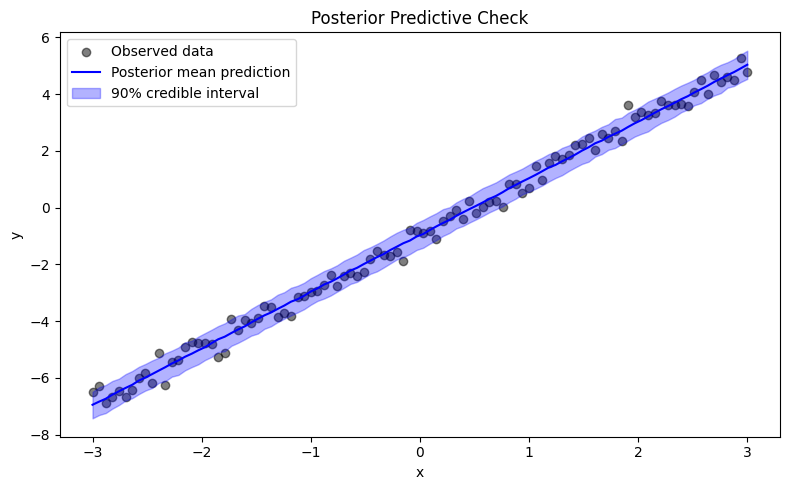

In [9]:
from numpyro.infer import Predictive

# Build predictive sampler from posterior
predictive = Predictive(linear_regression, posterior_samples=mcmc.get_samples())

# Generate predictions for observed x_data
predictions = predictive(jax.random.PRNGKey(1), x=x_data)

# Plot prediction band
y_pred = predictions["obs"]
mean_prediction = jnp.mean(y_pred, axis=0)
lower = jnp.percentile(y_pred, 5, axis=0)
upper = jnp.percentile(y_pred, 95, axis=0)

plt.figure(figsize=(8, 5))
plt.scatter(x_data, y_data, color="black", alpha=0.5, label="Observed data")
plt.plot(x_data, mean_prediction, color="blue", label="Posterior mean prediction")
plt.fill_between(x_data, lower, upper, color="blue", alpha=0.3, label="90% credible interval")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Posterior Predictive Check")
plt.legend()
plt.tight_layout()
plt.show()


### Part II — Cosmological Parameter Inference with NumPyro & jax-cosmo

In this example, we'll perform Bayesian inference on cosmological parameters  
using a simplified two-probe weak lensing + number counts setup from `jax-cosmo`.


In [10]:
# Imports
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import arviz as az
import corner


### Step 1 — Define fiducial cosmology and simulate data


In [11]:
# Fiducial cosmology
fiducial_cosmo = jc.Planck15()
ell = jnp.logspace(1, 3)

# Define redshift distributions for two tomographic bins
nz1 = jc.redshift.smail_nz(1., 2., 1.)
nz2 = jc.redshift.smail_nz(1., 2., 0.5)
nzs = [nz1, nz2]

# Define probes: Weak Lensing and Galaxy Counts
probes = [
    jc.probes.WeakLensing(nzs, sigma_e=0.26),
    jc.probes.NumberCounts(nzs, jc.bias.constant_linear_bias(1.0))
]


### Step 2 — Define NumPyro model for inference


In [ ]:
def model(data):
    Omega_c = ...
    sigma8 = ...
    cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)
    mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes)



### Simulating Observations from Planck15

Next, we use the handlers defined earlier (`condition`, `seed`, and `trace`) to generate simulated observables from the **Planck15** fiducial cosmology.
This will serve as the data input for the inference task that follows.


In [ ]:
from numpyro.handlers import seed, trace, condition

...
simulated_data = ...

/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


### Inferring Cosmological Parameters from Simulated Observations

We now use the simulated observable as input to our inference pipeline.

* The model is **not conditioned**.
* We aim to recover the true cosmological parameters (Ω<sub>c</sub>, σ₈) used to generate the data.
* We visualize the resulting posterior and compare it with the true values.


Bonus : add the truth markers (`truths=[...]`) to the plot too!


sample: 100%|██████████| 1500/1500 [04:08<00:00,  6.04it/s, 15 steps of size 8.23e-01. acc. prob=0.91]


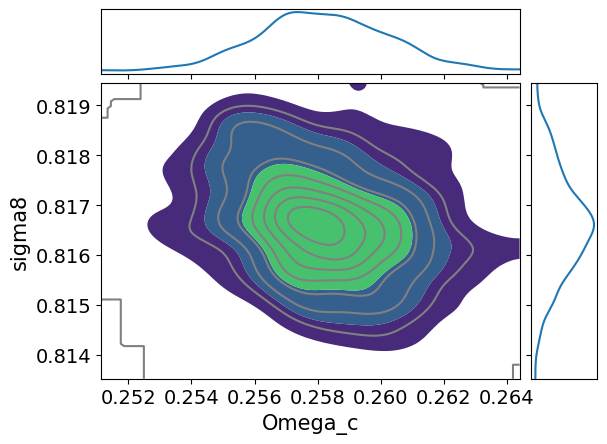

In [ ]:
# Step 1: Use the simulated data from the trace as "observed data"
obs_data = simulated_data  # from the previous trace
...


### Bonus Exercise: Using BlackJAX for Sampling

We’ve so far used **NumPyro's built-in NUTS sampler**. Now let’s switch to **BlackJAX**, a lightweight library that gives more control and flexibility.

In this exercise:

* Use `initialize_model` to extract the potential function from the model.
* Convert it into a **log-density** function for BlackJAX.
* Use `blackjax.window_adaptation` to automatically tune hyperparameters (step size, mass matrix).
* Sample using `blackjax.nuts`.
* Plot the posterior distribution of `Omega_c` and `sigma8` using **ArviZ**.

🔍 Hint: The interface is similar to NumPyro but requires more manual setup.

**Goal:** Recover the same posterior distribution using BlackJAX — and compare visually with your NumPyro result.



## Optional Exercise: Explore the Impact of the Prior

In Bayesian inference, the **prior** reflects your initial assumptions about the parameters — before seeing the data. In this example, we used:


```python
Omega_c = numpyro.sample("Omega_c", dist.Uniform(0.1, 0.5))
sigma8 = numpyro.sample("sigma8", dist.Uniform(0.6, 1.0))
```



### 🎯 Task:

Modify the prior on one or both parameters. For example:

* Try narrowing the range, e.g. `Uniform(0.2, 0.4)`
* Or use a `Normal` prior centered around a different value

Then re-run the inference and **compare the posterior** with the original.

You can use ArviZ's plot comparison utilities, or simply overlay KDE plots of the posteriors from different priors.

### 💡 Why?

This helps build intuition about how much the prior influences your inference — especially when the data is not very constraining.

### Bonus

compare two runs side-by-side:


Try it and see how sensitive your inference is to the pri

# Solution

Let’s modify the prior on `Omega_c` to be tighter and centered around a different value:


In [ ]:
def model_tighter_prior(data):
    ...

 Run inference

In [ ]:
kernel_tight = ...

sample: 100%|██████████| 1500/1500 [03:54<00:00,  6.41it/s, 3 steps of size 9.33e-01. acc. prob=0.88] 


Compare posteriors

/tmp/ipykernel_84197/1990314548.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


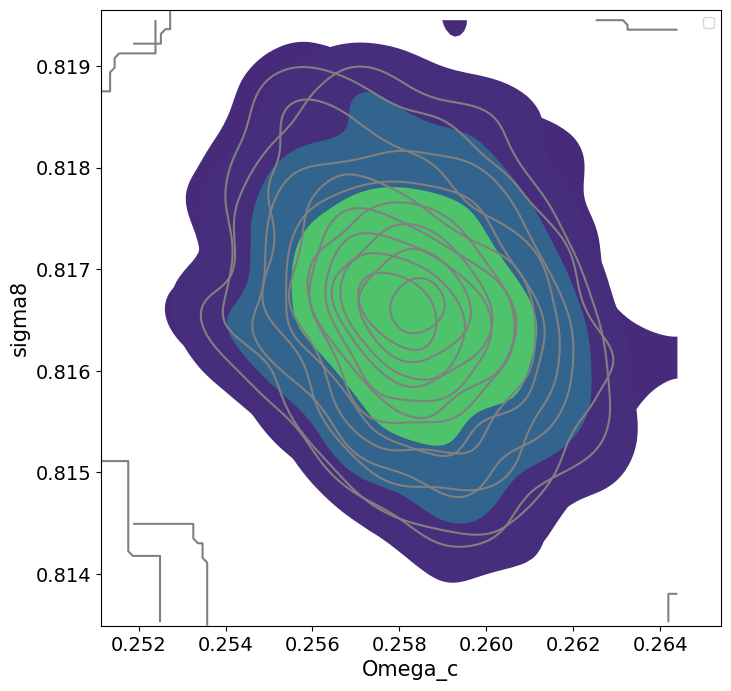

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

az.plot_pair(
    idata,
    var_names=["Omega_c", "sigma8"],  # replace with your actual parameter names
    kind='kde',
    ax=ax,
)

az.plot_pair(
    idata_tight,
    var_names=["Omega_c", "sigma8"],
    kind='kde',
    ax=ax,
)

ax.legend()
plt.show()
